<a href="https://colab.research.google.com/github/1985shree/1985shree/blob/main/tender_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing modules

In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

import os
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokenizer import Tokenizer
import re
import spacy
# nlp = spacy.load('en_core_web_lg')
# spacy_tokenizer = Tokenizer(nlp.vocab)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import save_npz, load_npz

import seaborn as sns
import matplotlib.pyplot as plt



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Importing dataset

In [3]:
items = pd.read_csv('items.csv')
userint = pd.read_csv('userInteractions.csv')
users = pd.read_csv('users.csv')


In [4]:
items.head()

,id,authority,publishingDate,bidDeadline,value,emd,status,locations,details
0,7e5e42eb-de7d-4b63-bd8c-9a842c445e66,Directorate Of Rural Development,1.645277e+12,1.645787e+12,300000.0,6000.0,CANCELLED,"[{'state': 'Jammu & Kashmir', 'city': 'Kathua'}]",Construction Of Community Sanitary Complex Uni...
1,828d3851-105f-4c24-ae68-c5b24597c7e7,Jharkhand State Rural Road Development Authority,1.645247e+12,1.646048e+12,16861000.0,339000.0,PUBLISHED,"[{'state': 'Jharkhand', 'city': 'Ranchi'}]",Repair And Maintenance Of Pmgsy Roads
2,673074b9-8592-4682-a4e4-ee388a1d86c5,Jharkhand State Rural Road Development Authority,1.645247e+12,1.646048e+12,32778000.0,656000.0,PUBLISHED,"[{'state': 'Jharkhand', 'city': 'West Singhbhu...",Repair And Maintenance Of Pmgsy Roads
3,836737ee-1d1d-4ae7-86f8-0c5abb8823c4,Jharkhand State Rural Road Development Authority,1.645247e+12,1.646048e+12,52264000.0,1045000.0,PUBLISHED,"[{'state': 'Jharkhand', 'city': 'Garhwa'}]",Repair And Maintenance Of Pmgsy Roads
4,929d94a1-0921-4625-9630-2720ee762f50,Rural Development Department,1.645270e+12,1.645760e+12,375755.0,NaN,ARCHIVED,"[{'state': 'Maharashtra', 'city': 'Nanded'}]",Construction Of Closed C.c. Drain / Road At Da...


In [5]:
items.shape

(76223, 9)

In [6]:
userint.head()

,activity,entityId,accountId
0,VIEWED,6658c6db-7b22-4612-b14b-edcdfe3f61c4,794928084817024957
1,DOWNLOADED,0c5b4a9d-21c8-428b-bce4-ee27556ba49d,794929730519308433
2,VIEWED,0c5b4a9d-21c8-428b-bce4-ee27556ba49d,794929730519308433
3,DOWNLOADED,817f9dbd-c37c-4e47-af18-01d3c2d25e41,794934903824193736
4,VIEWED,817f9dbd-c37c-4e47-af18-01d3c2d25e41,794934903824193736


In [7]:
userint.shape

(40466, 3)

In [8]:
users.head()

,accountId,filter
0,794928084817024957,"{'KEYWORD': ['Delhi', 'House Keeping']}"
1,794929730519308433,NaN
2,794934903824193736,"{'KEYWORD': ['Power'], 'PURCHASER_NAME': ['GUN..."
3,711046096666759540,{}
4,6599911511613774475,"{'LOCATION_STRING': ['Kerala'], 'KEYWORD': ['a..."


In [9]:
users.shape

(7566, 2)

In [10]:
user_df = users.merge(userint, how = 'left', on = 'accountId')

In [11]:
user_df.shape

(40466, 4)

In [12]:
user_df.head()

,accountId,filter,activity,entityId
0,794928084817024957,"{'KEYWORD': ['Delhi', 'House Keeping']}",VIEWED,6658c6db-7b22-4612-b14b-edcdfe3f61c4
1,794929730519308433,NaN,DOWNLOADED,0c5b4a9d-21c8-428b-bce4-ee27556ba49d
2,794929730519308433,NaN,VIEWED,0c5b4a9d-21c8-428b-bce4-ee27556ba49d
3,794934903824193736,"{'KEYWORD': ['Power'], 'PURCHASER_NAME': ['GUN...",DOWNLOADED,817f9dbd-c37c-4e47-af18-01d3c2d25e41
4,794934903824193736,"{'KEYWORD': ['Power'], 'PURCHASER_NAME': ['GUN...",VIEWED,817f9dbd-c37c-4e47-af18-01d3c2d25e41


<AxesSubplot:>

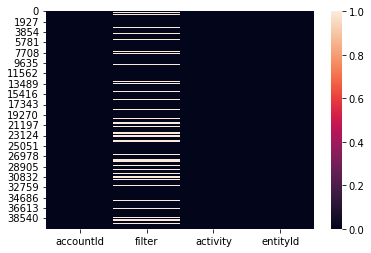

In [13]:
sns.heatmap(user_df.isnull())

In [14]:
# user_df.fillna(0)

In [15]:
df = user_df[user_df['filter'].notna()] #got rid of data without any info

In [16]:
df.duplicated().sum()

0

In [17]:
df.shape

(31742, 4)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31742 entries, 0 to 40461
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   accountId  31742 non-null  object
 1   filter     31742 non-null  object
 2   activity   31742 non-null  object
 3   entityId   31742 non-null  object
dtypes: object(4)
memory usage: 1.2+ MB


In [19]:
df.rename(columns = {'filter': 'use_details'}, inplace = True) # renamed because 'filter' is also a method and keeps interfering

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [20]:
df = df.reset_index(drop = True)

In [21]:
df.columns

Index(['accountId', 'use_details', 'activity', 'entityId'], dtype='object')

## Extract text from details column

In [22]:
df.use_details[10]

"{'LOCATION_STRING': ['Kerala'], 'KEYWORD': ['acp', 'exterior', 'glass', 'interior', 'structural glazing', 'truss'], 'VALUE': ['1000', '10000000']}"

In [23]:
json_data = json.loads(df.use_details[10].replace("'", '"'))
json_val = [val for k, val in json_data.items() if not k == 'VALUE']

In [24]:
json_val

[['Kerala'],
 ['acp', 'exterior', 'glass', 'interior', 'structural glazing', 'truss']]

In [25]:
def json_extractor_text(file):

  corrected = file.replace("'", '"')
  temp_data = json.loads(corrected)
  
  
    
  temp_value = [val for k, val in temp_data.items() if not k == 'VALUE']
  
  
  
  return ' '.join([item for sublist in temp_value for item in sublist])

def json_extractor_arg(file):
  try:
    return json_extractor_text(file)
  except:
    return ''
    



In [26]:
def json_extractor_value(file):

  corrected = file.replace("'", '"')
  temp_data = json.loads(corrected)
  
  
    
  temp_value = [val for k, val in temp_data.items() if k == 'VALUE']
  
  
  
  return [int(item) for sublist in temp_value for item in sublist]

def json_extractor_val_arg(file):
  try:
    return json_extractor_value(file)
  except:
    return ''

In [27]:
json_extractor_text(df.use_details[4])

'Kerala acp exterior glass interior structural glazing truss'

In [28]:
df['details_text'] = df.use_details.apply(lambda x: json_extractor_arg(x))

In [29]:
df['details_value'] = df.use_details.apply(lambda x: json_extractor_val_arg(x))

In [30]:
df['details_text'][0]

'Delhi House Keeping'

In [31]:
df['details_value'][10]

[1000, 10000000]

# performing NER to extract region information from details_text column.

In [32]:
! python -m spacy download en_core_web_lg

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-03-08 05:23:56.876266: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-08 05:23:56.876371: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-08 05:23:56.876391: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentione

In [33]:
nlp = spacy.load("en_core_web_lg")
nlp

In [34]:
def extract_locations(text_data):
  doc = nlp(text_data)
  gpe = []
  ent_lab = [e.label_ for e in doc.ents]
  # all_ents = [e.label_ for e in doc.ents if e.label_ == 'GPE' or e.label_ == 'NORP' or e.label_ == 'LOC']
  for ent in doc.ents:
    if ent.label_ == 'GPE':
      gpe.append(ent.text)
    elif ent.label_ == 'NORP':
      gpe.append(ent.text)
    elif ent.label_ == 'LOC':
      gpe.append(ent.text)
    elif ent.label_ == 'ORG':
      gpe.append(ent.text)
    else:
      None

  return ' '.join(gpe)

In [35]:
extract_locations(df.details_text[5000])


'IAF oxford rain'

##### Not doing it now

In [36]:
# df['loc_details'] = df.details_text.apply(lambda x: extract_locations(x))

In [37]:
# df['loc_details']

In [38]:
def custom_aggregation(*args):
  txt_list = []
  
  for arg in args:
    arg = arg[4:]
    
    txt_list.append(arg)

  if len(txt_list) >2 :

    return np.unique(txt_list).tolist()

  else:
    
    return txt_list


In [39]:
df.columns

Index(['accountId', 'use_details', 'activity', 'entityId', 'details_text',
       'details_value'],
      dtype='object')

In [40]:
df_activity = df.groupby('accountId')['details_text'].apply(lambda x: custom_aggregation(x)).to_frame()

In [41]:
df_activity.reset_index(inplace = True)

In [42]:
len(df_activity.details_text[0])

1

In [43]:
df_activity.head()

,accountId,details_text
0,6076439132127629518,[[]]
1,6090418399291119165,[[]]
2,6148417430046643859,"[[Andhra Pradesh Telangana Krishna, Andhra Pra..."
3,6180975557690267471,[[19 inch rack Angle Bracket for Step Hanger E...
4,6261728811314844815,[[3D PRINTING CMM INSPECTIONS Furniture GI W...


In [44]:
df_activity.details_text[30]

[2046    Plant and machinery scrap
 2047    Plant and machinery scrap
 2048    Plant and machinery scrap
 2049    Plant and machinery scrap
 2050    Plant and machinery scrap
 2051    Plant and machinery scrap
 Name: 6384313597467562204, dtype: object]

# modify items df

In [45]:
items.head()

,id,authority,publishingDate,bidDeadline,value,emd,status,locations,details
0,7e5e42eb-de7d-4b63-bd8c-9a842c445e66,Directorate Of Rural Development,1.645277e+12,1.645787e+12,300000.0,6000.0,CANCELLED,"[{'state': 'Jammu & Kashmir', 'city': 'Kathua'}]",Construction Of Community Sanitary Complex Uni...
1,828d3851-105f-4c24-ae68-c5b24597c7e7,Jharkhand State Rural Road Development Authority,1.645247e+12,1.646048e+12,16861000.0,339000.0,PUBLISHED,"[{'state': 'Jharkhand', 'city': 'Ranchi'}]",Repair And Maintenance Of Pmgsy Roads
2,673074b9-8592-4682-a4e4-ee388a1d86c5,Jharkhand State Rural Road Development Authority,1.645247e+12,1.646048e+12,32778000.0,656000.0,PUBLISHED,"[{'state': 'Jharkhand', 'city': 'West Singhbhu...",Repair And Maintenance Of Pmgsy Roads
3,836737ee-1d1d-4ae7-86f8-0c5abb8823c4,Jharkhand State Rural Road Development Authority,1.645247e+12,1.646048e+12,52264000.0,1045000.0,PUBLISHED,"[{'state': 'Jharkhand', 'city': 'Garhwa'}]",Repair And Maintenance Of Pmgsy Roads
4,929d94a1-0921-4625-9630-2720ee762f50,Rural Development Department,1.645270e+12,1.645760e+12,375755.0,NaN,ARCHIVED,"[{'state': 'Maharashtra', 'city': 'Nanded'}]",Construction Of Closed C.c. Drain / Road At Da...


In [46]:
def json_extractor_state(file):

  corrected = file.replace("'", '"')
  temp_data = json.loads(corrected)
  
  
    
  temp_value = [val for k, val in temp_data[0].items() if k == 'state']
  
  
  
  return ''.join([item for sublist in temp_value for item in sublist])
  # return temp_data

def json_extractor_state_arg(file):
  try:
    return json_extractor_state(file)
  except:
    return ''

In [47]:
json_extractor_state(items.locations[0])

'Jammu & Kashmir'

In [48]:
items['state'] = items.locations.apply(lambda x: json_extractor_state_arg(x))

In [49]:
items['state']

0        Jammu & Kashmir
1              Jharkhand
2              Jharkhand
3              Jharkhand
4            Maharashtra
              ...       
76218    Jammu & Kashmir
76219    Jammu & Kashmir
76220    Jammu & Kashmir
76221    Jammu & Kashmir
76222    Jammu & Kashmir
Name: state, Length: 76223, dtype: object

In [50]:
items.isnull().sum()

id                    0
authority            50
publishingDate      108
bidDeadline          78
value             30266
emd               38693
status               50
locations            50
details              51
state                 0
dtype: int64

In [51]:
items = items[items['details'].notna()].copy()

In [52]:
items.isnull().sum()

id                    0
authority             0
publishingDate       58
bidDeadline          28
value             30215
emd               38642
status                0
locations             0
details               0
state                 0
dtype: int64

In [53]:
df.shape

(31742, 6)

In [54]:
# def custom_aggregation(*args):
#   txt_list = []
#   for arg in args:
#     arg = arg[8:]
#     txt_list.append(arg)
#   if len(txt_list) > 1:
#     res =  np.unique(txt_list).tolist()
#   else: 
#     res =  txt_list
#   return res


  


In [55]:
# custom_aggregation('oneoneone', 'oneoneone', 'twotwo', 'three')

In [56]:
# df.columns

In [57]:
# df_group = df.groupby('accountId')['details_text'].apply(lambda x: custom_aggregation(x)).to_frame()

In [58]:
df_group = df.groupby('accountId')['details_text'].apply(list).to_frame()

In [59]:
df_group = df_group.reset_index()

In [60]:
df_group.head()

,accountId,details_text
0,6076439132127629518,[Andhra Pradesh Administration All ASTM D Buil...
1,6090418399291119165,[ENABLE_EXACT_SEARCH ERW Black Pipe ERW Pipes ...
2,6148417430046643859,"[Andhra Pradesh Telangana Krishna, Andhra Prad..."
3,6180975557690267471,[19 inch rack Angle Bracket for Step Hanger En...
4,6261728811314844815,[3D PRINTING CMM INSPECTIONS Furniture GI Wi...


In [61]:
def filter_duplicates(lst):
  unique_lst = []
  dup_list = []
  for v in lst:
    if v not in unique_lst:
      unique_lst.append(v)
    else:
      dup_list.append(v)
  return ''.join(unique_lst)

In [62]:
df_group['unique_details'] = df_group.details_text.apply(lambda x: filter_duplicates(x))

# creating a recommender

#### first let's make a content-based one (based on cosine similarity)

In [63]:
df.head()

,accountId,use_details,activity,entityId,details_text,details_value
0,794928084817024957,"{'KEYWORD': ['Delhi', 'House Keeping']}",VIEWED,6658c6db-7b22-4612-b14b-edcdfe3f61c4,Delhi House Keeping,[]
1,794934903824193736,"{'KEYWORD': ['Power'], 'PURCHASER_NAME': ['GUN...",DOWNLOADED,817f9dbd-c37c-4e47-af18-01d3c2d25e41,Power GUNTUR DIV,[]
2,794934903824193736,"{'KEYWORD': ['Power'], 'PURCHASER_NAME': ['GUN...",VIEWED,817f9dbd-c37c-4e47-af18-01d3c2d25e41,Power GUNTUR DIV,[]
3,711046096666759540,{},VIEWED,6b781175-a6f9-47ea-80f1-74e7a26a4140,,[]
4,6599911511613774475,"{'LOCATION_STRING': ['Kerala'], 'KEYWORD': ['a...",VIEWED,41c63df6-482e-48d5-99e3-1ac95fbb8894,Kerala acp exterior glass interior structural ...,"[1000, 10000000]"


### cleaning text function

In [64]:
def clean_string(text,stem="None"):

    final_string = ""

    # make lower
    text = text.lower()
    
    # remove http
    text = re.sub(r"http.*\.[a-z]{2,3}","",text)

    # remove www
    text = re.sub(r"www.*\.[a-z]{2,3}","",text)
    
    # remove line breaks
    text = re.sub(r'\n','',text)

    # remove puncuation
    translator = str.maketrans('','',string.punctuation)
    text = text.translate(translator)

    # remove stop words
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    useless_words.remove("don't")
    useless_words.remove('not')

    text_filtered = [word for word in text if not word in useless_words]

    # remove numbers
    text_filtered = [re.sub(r'\w*\d\w*','',w) for w in text_filtered]

    # stem or lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    elif stem == 'Spacy':
        text_filtered = nlp(' '.join(text_filtered))
        text_stemmed = [y.lemma_ for y in text_filtered]
    else:
        text_stemmed = text_filtered

    final_string = ' '.join(text_stemmed)

    return final_string
        
def apply_clean_string(df):
   arr = df.apply(lambda x: clean_string(str(x)))
   return pd.DataFrame(arr)  

In [65]:
items['clean_text'] = items.details.apply(lambda x: clean_string(x,stem="None"))

In [66]:
items.head()

,id,authority,publishingDate,bidDeadline,value,emd,status,locations,details,state,clean_text
0,7e5e42eb-de7d-4b63-bd8c-9a842c445e66,Directorate Of Rural Development,1.645277e+12,1.645787e+12,300000.0,6000.0,CANCELLED,"[{'state': 'Jammu & Kashmir', 'city': 'Kathua'}]",Construction Of Community Sanitary Complex Uni...,Jammu & Kashmir,construction community sanitary complex unit n...
1,828d3851-105f-4c24-ae68-c5b24597c7e7,Jharkhand State Rural Road Development Authority,1.645247e+12,1.646048e+12,16861000.0,339000.0,PUBLISHED,"[{'state': 'Jharkhand', 'city': 'Ranchi'}]",Repair And Maintenance Of Pmgsy Roads,Jharkhand,repair maintenance pmgsy roads
2,673074b9-8592-4682-a4e4-ee388a1d86c5,Jharkhand State Rural Road Development Authority,1.645247e+12,1.646048e+12,32778000.0,656000.0,PUBLISHED,"[{'state': 'Jharkhand', 'city': 'West Singhbhu...",Repair And Maintenance Of Pmgsy Roads,Jharkhand,repair maintenance pmgsy roads
3,836737ee-1d1d-4ae7-86f8-0c5abb8823c4,Jharkhand State Rural Road Development Authority,1.645247e+12,1.646048e+12,52264000.0,1045000.0,PUBLISHED,"[{'state': 'Jharkhand', 'city': 'Garhwa'}]",Repair And Maintenance Of Pmgsy Roads,Jharkhand,repair maintenance pmgsy roads
4,929d94a1-0921-4625-9630-2720ee762f50,Rural Development Department,1.645270e+12,1.645760e+12,375755.0,NaN,ARCHIVED,"[{'state': 'Maharashtra', 'city': 'Nanded'}]",Construction Of Closed C.c. Drain / Road At Da...,Maharashtra,construction closed cc drain road dapka gundop...


In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


tfidf = TfidfVectorizer(stop_words="english", min_df=1)

In [73]:
trainVectorizerArray = tfidf.fit_transform(df_group['unique_details']).toarray()
testVectorizerArray = tfidf.transform(items['clean_text']).toarray()

In [74]:
import numpy.linalg as LA
cx = lambda a, b : round(np.inner(a, b)/(LA.norm(a)*LA.norm(b)), 3)

## running with a subset of data as pilot batch

In [82]:
cosine_all = []
idx = []
for i, vector in enumerate(trainVectorizerArray[:1000]):
  # print vector
  cosine = []
  
  for testV in testVectorizerArray[:10]:
    # print testV
    cosine.append(cx(vector, testV))

  cosine_all.append(cosine)
  idx.append(i)

<ipython-input-74-0bdad5d36d50>:2: RuntimeWarning: invalid value encountered in double_scalars
  cx = lambda a, b : round(np.inner(a, b)/(LA.norm(a)*LA.norm(b)), 3)


In [91]:
cosine_all = []
test_idx_all = []
idx = []
for i, vector in enumerate(testVectorizerArray[:10]):
  # print vector
  cosine = []
  test_idx = []
  for j, trainV in enumerate(trainVectorizerArray[:1000]):
    # print testV
    cosine.append(cx(vector, trainV))
    test_idx.append(j)
  cosine_all.append(cosine)
  test_idx_all.append(test_idx)
  idx.append(i)

<ipython-input-74-0bdad5d36d50>:2: RuntimeWarning: invalid value encountered in double_scalars
  cx = lambda a, b : round(np.inner(a, b)/(LA.norm(a)*LA.norm(b)), 3)


In [110]:
cosine_dict = {'user_idx': idx, 'cosine_sim': cosine_all, 'item_idx': test_idx_all}
recommender_df = pd.DataFrame(cosine_dict)

In [102]:
cosine_sim_array = np.array(cosine_all)
cosine_sim_array[np.isnan(cosine_sim_array)] = 1

In [108]:
sorted_item_idx = []
for i in cosine_sim_array:
  sorted_item_idx.append(np.argsort(i)[:10])


In [109]:
sorted_item_idx

[array([262, 668, 670, 671, 347, 674, 675, 344, 676, 677]),
 array([  0, 779, 410, 777, 412, 774, 414, 772, 416, 770]),
 array([  0, 779, 410, 777, 412, 774, 414, 772, 416, 770]),
 array([  0, 779, 410, 777, 412, 774, 414, 772, 416, 770]),
 array([273, 347, 701, 702, 344, 704, 706, 340, 339, 338]),
 array([  0, 582, 583, 584, 585, 587, 588, 589, 590, 591]),
 array([  0, 553, 556, 558, 559, 562, 567, 568, 569, 571]),
 array([269, 360, 359, 678, 357, 356, 679, 680, 681, 683]),
 array([  0, 582, 583, 584, 585, 587, 588, 589, 590, 591]),
 array([  0, 577, 580, 581, 582, 583, 584, 585, 587, 588])]

In [112]:
recommender_df['item_index_recommendation'] = sorted_item_idx

## Result: column item_index_recommendation lists 1st 10 item (i.e. tender item dataframe) indices for each user index. The indices can be traced back to the respective dataframes. Essentially, this is the first version of content-based recommender.

In [113]:
recommender_df.head()

,user_idx,cosine_sim,item_idx,item_index_recommendation
0,0,"[0.028, 0.0, 0.0, 0.0, 0.0, 0.0, 0.019, 0.0, 0...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[262, 668, 670, 671, 347, 674, 675, 344, 676, ..."
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.087, 0.0, 0.0...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 779, 410, 777, 412, 774, 414, 772, 416, 770]"
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.087, 0.0, 0.0...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 779, 410, 777, 412, 774, 414, 772, 416, 770]"
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.087, 0.0, 0.0...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 779, 410, 777, 412, 774, 414, 772, 416, 770]"
4,4,"[0.064, 0.0, 0.0, 0.0, 0.0, 0.0, 0.043, 0.0, 0...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[273, 347, 701, 702, 344, 704, 706, 340, 339, ..."
